In [19]:
import os
import shutil
import pandas as pd
from PIL import Image
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

img_rows = 150
img_cols = 224
color_type = 3
batch_size=48
epochs=300
subject='Melanoma'
main_path=os.path.join("E:\\kaggle_imgs",subject)
img_path=os.path.join(main_path,"images")
data_path=os.path.join(main_path,"Data")
saved_path=os.path.join(main_path,"saved_models")
paths=[main_path, img_path,saved_path,data_path]
for fp in paths:
    print(fp)
    if not os.path.exists(fp):        
        os.mkdir(fp)
file_path=os.path.join(saved_path,"200621_")
file_best=os.path.join(saved_path,"200621_")

train_img_pkl=os.path.join(data_path,"train_imgs.npy")
test_img_pkl=os.path.join(data_path,"test_imgs.npy")
train_info_pkl=os.path.join(data_path,"df_train_pickle.csv")

num_classes=4

E:\kaggle_imgs\Melanoma
E:\kaggle_imgs\Melanoma\images
E:\kaggle_imgs\Melanoma\saved_models
E:\kaggle_imgs\Melanoma\Data


In [20]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
# import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [21]:
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

## Load train Data


In [22]:
train_df = pd.read_csv(os.path.join(data_path,"train.csv"))
test_df = pd.read_csv(os.path.join(data_path,"test.csv"))

In [23]:
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

## Advanced Aug

In [24]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [25]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

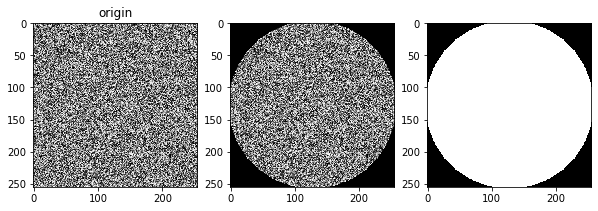

In [26]:
## My Test

img=np.random.randint(0,256,(255,255))
circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
            (img.shape[0]//2, img.shape[1]//2), # center point of circle
            random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
            (0, 0, 0), # color
            -1)
mask = circle - 255
img2 = np.multiply(img, mask)

f,ax=plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(img,cmap="gray"),ax[0].set_title("origin")
ax[1].imshow(img2,cmap="gray")
ax[2].imshow(mask,cmap="gray")

## Augmentation

In [49]:
train_transform = transforms.Compose([
#    AdvancedHairAugmentation(hairs_folder='/kaggle/input/melanoma-hairs/'),
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
#    Microscope(p=0.6),
#     transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
my_transform = transforms.Compose([
#     transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

## Dataset

In [50]:
from PIL import Image
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, 
                 transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
#         x = cv2.imread(im_path)
        x=Image.open(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
             x = self.transforms(x)

            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)

## Model

In [51]:
arch = EfficientNet.from_pretrained('efficientnet-b1') 
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [52]:
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [53]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b1 NN architecture
# skf = StratifiedKFold(n_splits=5, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [54]:
test = MelanomaDataset(df=test_df,
                       imfolder='/kaggle/input/melanoma-external-malignant-256/test/test/', 
                       train=False,
                       transforms=train_transform,
                       meta_features=meta_features)

In [55]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10  # Number of epochs to run
model_path = 'model.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

In [56]:
def get_split_data(train_idx,val_idx):
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), \
                            imfolder=img_path+"/jpeg/train/", 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                          imfolder=img_path+"/jpeg/train/", 
                          train=True, 
                          transforms=test_transform,
                          meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=0)
    
    return train_loader,val_loader,test_loader


In [57]:
X=np.zeros(len(train_df))
y=train_df['target']
for fold, (train_idx, val_idx) in enumerate(skf.split(X,y, groups=train_df['patient_id'].tolist()), 1):
    break

train_loader,val_loader,test_loader=get_split_data(train_idx, val_idx)

In [58]:
for img,lab in train_loader:
    break

In [62]:
# We stratify by target value, thus, according to sklearn StratifiedKFold documentation
# We can fill `X` with zeroes of corresponding length to use it as a placeholder
# since we only need `y` to stratify the data
# for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
X=np.zeros(len(train_df))
y=train_df['target']
for fold, (train_idx, val_idx) in enumerate(skf.split(X,y, groups=train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    
    best_val = None  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = EfficientNet.from_pretrained('efficientnet-b1')
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train_loader,val_loader,test_loader =  get_split_data(train_idx,val_idx)
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)

        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
            # During the first iteration (first epoch) best validation is set to None
            if not best_val:
                best_val = val_roc  # So any validation roc_auc we have is the best one for now
                torch.save(model, model_path)  # Saving the model
                continue
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
        preds /= TTA
        
    del train, val, train_loader, val_loader, x, y, x_val, y_val
    gc.collect()
    
preds /= skf.n_splits

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1


RuntimeError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 8.00 GiB total capacity; 5.91 GiB already allocated; 25.97 MiB free; 5.99 GiB reserved in total by PyTorch)

## define value tracker

In [ ]:
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append'
             )

## Load train data

In [ ]:
def read_train_info():
    fp=train_info_pkl
    if False and os.path.exists(fp):
        try:
            print('loading train data from csv', flush=True)
            df_train=pd.read_csv(fp)
            print('complete!', flush=True)
        except EOFError:
            print('EOFError raised.', flush=True)
        
    else:
        df_train=pd.read_csv(data_path+"/train.csv")
        df_train["CAT"]=df_train[['healthy', 'multiple_diseases', 'rust','scab']].values.argmax(axis=1)
        df_train["id"]=df_train["image_id"].apply(lambda x : int(x.split("_")[1]))        
        X=df_train['id'].values
        y=df_train['CAT'].values
        skf=StratifiedKFold(n_splits=5,random_state=22)        
        df_train["fold"]=-1
        sum=0
        for i, (trn_idx,vld_idx) in enumerate(skf.split(X,y)):
            df_train.loc[vld_idx,"fold"]=i
        df_train.to_csv(train_info_pkl,index=False)
        
    return df_train

df_train=read_train_info()


## Augmentation

In [ ]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
    transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

transform_valid = transforms.Compose([
    transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, Cutout, HorizontalFlip, Normalize
)
from albumentations.pytorch import ToTensor, ToTensorV2
transform_train= Compose([
    Rotate(20),
    ToTensor()
])
transform_valid=Compose([
    ToTensor()
])

## Dataset

In [ ]:
from torch.utils.data import Dataset
class PlantDataset(Dataset):
    def __init__(self, df, tr=None):
        self.df = df
        self.tr=tr
        
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        name=self.df.iloc[idx].image_id
        image_src=img_path+"/"+name+".jpg"
        image = Image.open(image_src)
        labels = self.df.iloc[idx].CAT

        if self.tr is not None:
            image=self.tr(image)
        
        return image, labels

## transforms and normalization

In [ ]:
sel=1
trn_fold=[i for i in range(5) if i not in [sel]]
val_fold=[i for i in range(5) if i in [sel]]
trn_idx=df_train[df_train.fold.isin(trn_fold)].index
val_idx=df_train[df_train.fold.isin(val_fold)].index
print(trn_idx.shape,val_idx.shape)

In [ ]:
trainset = PlantDataset(df=df_train.loc[trn_idx],
                       tr=transform_train)
validset =PlantDataset(df=df_train.loc[val_idx],
                      tr=transform_valid)

train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validset,
                                          batch_size=batch_size,
                                          shuffle=False, num_workers=0)

In [ ]:
for img,lab in train_loader:
    break

In [ ]:
plt.imshow(img[0].permute(1,2,0))

## Model

In [ ]:
# import torchvision.models.resnet as resnet

In [ ]:
# conv1x1=resnet.conv1x1
# Bottleneck = resnet.Bottleneck
# BasicBlock= resnet.BasicBlock

In [ ]:
# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
#         super(ResNet, self).__init__()
#         self.inplanes = 16
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU(inplace=True)
#         #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
#         self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
#         self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(128 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#         # Zero-initialize the last BN in each residual branch,
#         # so that the residual branch starts with zeros, and each residual block behaves like an identity.
#         # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         #[-1,3,32,32]
#         x = self.conv1(x)
#         #x.shape =[1, 16, 32,32]
#         x = self.bn1(x)
#         x = self.relu(x)
#         #x = self.maxpool(x)

#         x = self.layer1(x)
#         #x.shape =[1, 128, 32,32]
#         x = self.layer2(x)
#         #x.shape =[1, 256, 32,32]
#         x = self.layer3(x)
#         #x.shape =[1, 512, 16,16]
#         x = self.layer4(x)
#         #x.shape =[1, 1024, 8,8]
        
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x

In [ ]:
import torchvision.models  as models
import torch.nn as nn

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
resnet34 = models.resnet34(pretrained=True)
num_ftrs=resnet34.fc.in_features
resnet34.fc=nn.Linear(num_ftrs,num_classes)

In [ ]:
resnet34=resnet34.to(device)

In [ ]:
a=torch.Tensor(1,3,img_rows,img_cols).to(device)
out = resnet34(a)
print(out)

In [ ]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.SGD(resnet34.parameters(),lr=1e-2,momentum=0.9,weight_decay=5e-4)
lr_sched=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

## make plot

In [ ]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),
                    opts=dict(title='loss_tracker', 
                              legend=['loss'], 
                              showlegend=True))
acc_plt = vis.line(Y=torch.Tensor(1).zero_(),
                   opts=dict(title='Accuracy', 
                             legend=['Acc'],
                             showlegend=True))

## define acc check func

In [ ]:
best_acc=0
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    global best_acc
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save and best_acc<acc:
        best_acc=acc
        torch.save(net.state_dict(), file_path+"_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

## train

In [ ]:

print(len(train_loader))
epochs = 10

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    lr_sched.step()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(train_loader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(resnet34, valid_loader, epoch, save=1)
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

In [ ]:
print(len(train_loader))

In [ ]:
torch.cuda.current_stream()

In [ ]:
torch.cuda.device_count()

In [ ]:
torch.cuda.empty_cache()